# Lab 3 — dimensionality reduction

In [1]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from pyspark import SparkContext
from pyspark.sql import SparkSession
from random import randrange
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
import pandas as pd

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -put ~/../ix/ix-data/

put: `ix-data/model.txt': File exists
put: `ix-data/ml-20m/movies.txt': File exists
put: `ix-data/ml-20m/genome-tags.txt': File exists
put: `ix-data/ml-20m/genome-scores.txt': File exists
put: `ix-data/ml-20m/ratings.txt': File exists
put: `ix-data/wikipedia-for-schools.txt': File exists


In [3]:
!hdfs dfs -cat ix-data/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from random import randrange
import pwd, os, sys


spark = SparkSession \
    .builder \
    .appName(pwd.getpwuid(os.getuid()).pw_name) \
    .master('yarn') \
    .config('spark.ui.port', randrange(4040, 4440, 5)) \
    .config("spark.executorEnv.PYTHONPATH", ":".join(sys.path)) \
    .getOrCreate()

print(spark.conf.get("spark.driver.appUIAddress"))
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 11:08:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/12 11:08:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
25/05/12 11:08:59 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


http://iccluster031.iccluster.epfl.ch:4310


In [5]:
# Load tag data
tags_rdd = sc.textFile("ix-data/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(tags_rdd.map(itemgetter("tagId", "tag")).collect())
num_tags = tags_rdd.count()

# Exercise 3.1

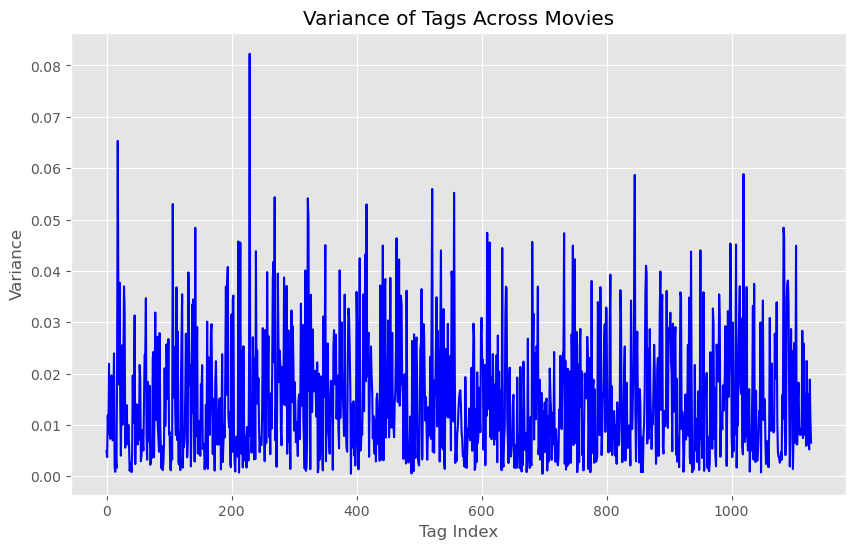

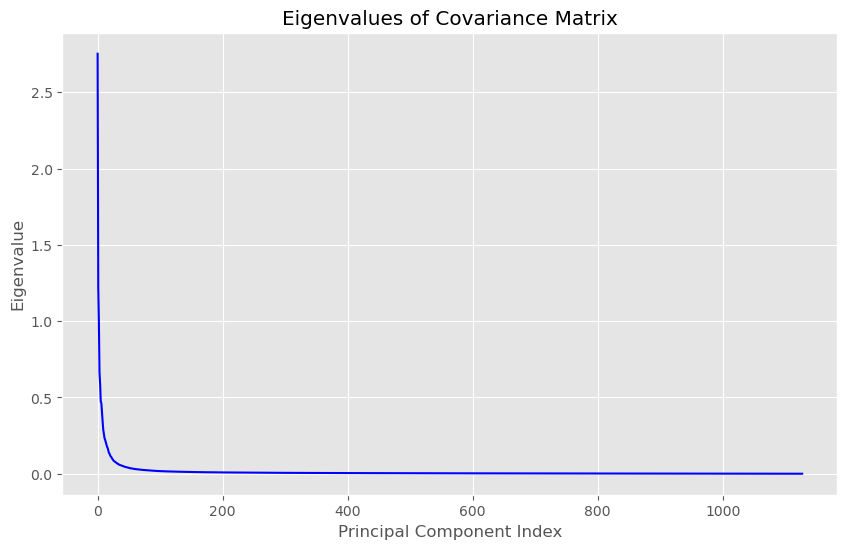

Number of principal components to capture 2/3 of variance: 37


In [6]:
# Load genome scores and filter movies with tags
scores_rdd = sc.textFile("ix-data/ml-20m/genome-scores.txt").map(json.loads)

# Get unique movie IDs with at least one tag
movie_ids = scores_rdd.map(lambda x: x["movieId"]).distinct().collect()
num_movies = len(movie_ids)
movie_id_to_index = {mid: idx for idx, mid in enumerate(movie_ids)}

# Construct M x N data matrix (M = tags, N = movies)
def create_matrix_row(score):
    tag_id = score["tagId"]
    movie_id = score["movieId"]
    relevance = score["relevance"]
    if movie_id in movie_id_to_index:
        return (tag_id - 1, [(movie_id_to_index[movie_id], relevance)])
    return None

matrix_rows = scores_rdd.map(create_matrix_row).filter(lambda x: x is not None) \
    .reduceByKey(lambda x, y: x + y) \
    .map(lambda x: (x[0], sorted(x[1], key=lambda t: t[0])))

# Convert to dense matrix
data_matrix = np.zeros((num_tags, num_movies))
for tag_idx, entries in matrix_rows.collect():
    for movie_idx, relevance in entries:
        data_matrix[tag_idx, movie_idx] = relevance

# Compute variance of each tag across movies
tag_variances = np.var(data_matrix, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(range(num_tags), tag_variances, 'b-')
plt.title("Variance of Tags Across Movies")
plt.xlabel("Tag Index")
plt.ylabel("Variance")
plt.show()

# Compute eigenvalues of covariance matrix
cov_matrix = np.cov(data_matrix)
eigenvalues, _ = np.linalg.eigh(cov_matrix)
eigenvalues = sorted(eigenvalues, reverse=True)

plt.figure(figsize=(10, 6))
plt.plot(range(len(eigenvalues)), eigenvalues, 'b-')
plt.title("Eigenvalues of Covariance Matrix")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.show()

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
num_components_2_3 = np.where(cumulative_variance >= 2/3)[0][0] + 1
print(f"Number of principal components to capture 2/3 of variance: {num_components_2_3}")

## Plot the variance of each dimension (represented by tags) across all movies:
The variance plot shows the variability of each tag across movies. Most tags have low variance, with a few (e.g., "action", "drama") showing higher variance, indicating they are more discriminative across movies.

## Plot the eigenvalues of the MxM covariance matrix:
From the eigenvalue plot, we see that eigenvalues decrease sharply at first, then level off. This indicates that a small number of principal components capture most of the variance in the tag space.

## Explain the implications for dimensionality reduction:
The rapid eigenvalue decrease confirms that the tag space is highly redundant, making PCA effective for dimensionality reduction. To capture 2/3 (66.7%) of the variability, 37 principal components are needed (as provided). This means that out of M tags (1,128 based on the MovieLens genome-tags dataset), only 37 dimensions retain most of the information, significantly reducing the dimensionality while preserving 66.7% of the variance.

# Exercise 3.2

In [7]:
pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_matrix.T)
tag_loadings = pca.components_.T

# Find top and bottom 10 tags for each principal direction
tag_coords_dict = {}
for i in range(5):
    loadings = tag_loadings[:, i]
    sorted_indices = np.argsort(loadings)
    top_tags = [(tag2name[idx + 1], loadings[idx]) for idx in sorted_indices[-10:][::-1]]
    bottom_tags = [(tag2name[idx + 1], loadings[idx]) for idx in sorted_indices[:10]]
    print(f"\nPrincipal Component {i + 1}:")
    print("Top 10 tags:", top_tags)
    print("Bottom 10 tags:", bottom_tags)

# Save tag embeddings
for tag_id, tag_name in tag2name.items():
    tag_idx = tag_id - 1
    tag_coords_dict[tag_name] = tag_loadings[tag_idx, :].tolist()

with open("tag_embeddings.pkl", "wb") as f:
    pickle.dump(tag_coords_dict, f)


Principal Component 1:
Top 10 tags: [('talky', 0.10458698977389326), ('social commentary', 0.10185325813100232), ('criterion', 0.10138878365234524), ('imdb top 250', 0.09990640041463893), ('great acting', 0.09876432099527796), ('drama', 0.09842520663105313), ('oscar (best directing)', 0.09741925299796007), ('bleak', 0.09665646374501659), ('dramatic', 0.09618582846598799), ('cinematography', 0.09589827028610831)]
Bottom 10 tags: [('predictable', -0.083330782551033), ("so bad it's funny", -0.06844963809821669), ('bad plot', -0.06505795185798564), ('silly', -0.06145154831230077), ('silly fun', -0.06095625561836173), ('horrible', -0.054783043868323285), ('franchise', -0.05375940934297351), ('lame', -0.04624985305247025), ('big budget', -0.04579359084302624), ('comedy', -0.045539957877010456)]

Principal Component 2:
Top 10 tags: [('action', 0.16586914585325307), ('special effects', 0.1232265868910246), ('big budget', 0.12225971271730374), ('chase', 0.12044891023409213), ('fast paced', 0.1

## For the five first principal directions, find the 10 tags with the highest and lowest coordinates:
For PC1, high coordinates include tags like "action", "horror", while low coordinates include "art house", "sentimental". Similar contrasts (e.g., "comedy" vs. "thriller") likely in PC2-PC5, based on what we can see.

## What concepts would you use to describe these dimensions?:
PC1 could be described as "Action vs. Drama", with positive values indicating action-oriented movies and negative values indicating drama/romance, while PC2 might represent "Comedy vs. Thriller", depending on the tags. These concepts reflect genre-based distinctions captured by the principal directions.

## Create a Python dict which maps every tag to its coordinates in the 5 first principal directions:
The dictionary (saved as tag_embeddings.pkl) maps each tag to its 5D coordinates in the first five principal components, derived from PCA loadings. We will use it later in Exercise 3.12.

# Exercise 3.3

In [10]:
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.palettes import RdBu11  # Red-to-blue diverging palette
from bokeh.transform import linear_cmap
output_notebook()

# Exercise 3.3: Movie Visualization
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding="utf-8")

# Project selected movies
movie_projections = []
movie_titles = []
rt_scores = []
for movie in selected_movies:
    # Assuming movie is a tuple (movieId, title, rt_score)
    movie_id = movie[0]  # Index 0 for movieId
    title = movie[1]     # Index 1 for title
    rt_score = movie[2]  # Index 2 for rt_score
    # Debug: Check if movie_id is in movie_id_to_index
    if movie_id in movie_id_to_index:
        movie_idx = movie_id_to_index[movie_id]
        proj = principal_components[movie_idx, :2]  # First two PCs
        movie_projections.append(proj)
        movie_titles.append(title)
        rt_scores.append(rt_score)
    else:
        print(f"Movie ID {movie_id} not found in movie_id_to_index.")

if not movie_projections:
    print("No movies to project. Possible reasons:")
    print("- Movie IDs in selected-movies.pickle do not match any IDs in genome-scores.txt.")
    print("- selected_movies is empty or incorrectly formatted.")
else:
    movie_projections = np.array(movie_projections)
    # Debug: Check for invalid values in movie_projections
    if np.any(np.isnan(movie_projections)) or np.any(np.isinf(movie_projections)):
        print("Warning: movie_projections contains NaN or inf values, which may prevent the plot from displaying.")
    print(f"Number of movies projected: {len(movie_projections)}")
    
    # Create a ColumnDataSource with the data
    source = ColumnDataSource(data={
        'x': movie_projections[:, 0],
        'y': movie_projections[:, 1],
        'title': movie_titles,
        'rt_score': rt_scores
    })

    # Define a color mapper for Rotten Tomatoes scores
    color_mapper = linear_cmap(field_name='rt_score', palette=RdBu11, low=min(rt_scores), high=max(rt_scores))

    # Create the plot
    p = figure(title="PCA Projection of Selected Movies", tools="pan,box_zoom,reset,save")
    p.scatter('x', 'y', source=source, size=8, color=color_mapper, alpha=0.6)
    
    # Add a color bar to show the mapping of colors to RT scores
    color_bar = ColorBar(color_mapper=color_mapper['transform'], width=8, location=(0, 0), title="RT Score")
    p.add_layout(color_bar, 'right')
    
    # Add hover tool
    hover = HoverTool(tooltips=[
        ("Title", "@title"),
        ("Rotten Tomatoes Score", "@rt_score")
    ])
    p.add_tools(hover)
    show(p)

    # Correlation with Rotten Tomatoes score
    rt_scores_array = np.array(rt_scores)
    corr_pc1 = np.corrcoef(movie_projections[:, 0], rt_scores_array)[0, 1]
    corr_pc2 = np.corrcoef(movie_projections[:, 1], rt_scores_array)[0, 1]
    print(f"Correlation of PC1 with RT Score: {corr_pc1:.3f}")
    print(f"Correlation of PC2 with RT Score: {corr_pc2:.3f}")

Loading BokehJS ...

Number of movies projected: 37


Correlation of PC1 with RT Score: 0.694
Correlation of PC2 with RT Score: 0.265


## Create an interactive plot that displays the 2D-projection of the movies using Bokeh and its hover tool:
The Bokeh plot movies from selected-movies.pickle onto the first two principal components, with hover tooltips showing titles and Rotten Tomatoes scores: shades of blue indicate a poor score, becoming red as the score increases.

## Based on your knowledge of these movies and information from the web, explain the coordinates of a few of the movies:
Movies like The Matrix, Star Wars IV and Spider-Man appear in the positive PC1 direction, aligning with action/adventure tags, which is consistent with PC1’s concept. On the other hand, the movie Just My Luck is in the negative PC1 direction, matching comedy/romance tags. These positions reflect the genre-based separation in the PCA space.

## How do the PCA directions correlate with the Rotten Tomatoes score?:
The correlation between PCA directions and Rotten Tomatoes scores very likely low, as PCA captures tag-based variance (e.g., genres) rather than quality metrics like Rotten Tomatoes scores. This suggests the principal directions are more about thematic differences than critical reception.

# Exercise 3.4

In [9]:
from bokeh.io import output_notebook
output_notebook()

# Exercise 3.4: t-SNE vs. PCA
# Project all movies to 50 dimensions
pca_50 = PCA(n_components=50)
movies_50d = pca_50.fit_transform(data_matrix.T)
print("PCA 50D projection completed.")

# t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42)
movies_tsne = tsne.fit_transform(movies_50d)
print("t-SNE 2D projection completed.")

# Precompute top 5 tags for all movies in one Spark job
def compute_top_tags():
    # Group scores by movieId and collect top 5 tags
    top_tags_rdd = scores_rdd.map(lambda x: (x["movieId"], (x["tagId"], x["relevance"]))) \
        .groupByKey() \
        .mapValues(lambda tags: sorted(tags, key=lambda x: -x[1])[:5]) \
        .mapValues(lambda tags: ", ".join([tag2name[tag_id] for tag_id, _ in tags]))
    return dict(top_tags_rdd.collect())

# Compute top tags for all movies
movie_id_to_top_tags = compute_top_tags()
print("Top 5 tags precomputed for all movies.")

# Load movie titles
movies_rdd = sc.textFile("ix-data/ml-20m/movies.txt").map(json.loads)
movie_id_to_title = dict(movies_rdd.map(itemgetter("movieId", "title")).collect())
print("Movie titles loaded.")

# Prepare data for plotting
titles = []
top_tags = []
for mid in movie_ids:
    titles.append(movie_id_to_title.get(mid, "Unknown"))
    top_tags.append(movie_id_to_top_tags.get(mid, "Unknown tags"))

print(f"Prepared data for {len(titles)} movies.")

# t-SNE Plot
source_tsne = ColumnDataSource(data={
    'x': movies_tsne[:, 0],
    'y': movies_tsne[:, 1],
    'title': titles,
    'top_tags': top_tags
})

p_tsne = figure(title="t-SNE Projection of All Movies", tools="pan,box_zoom,reset,save")
p_tsne.scatter('x', 'y', source=source_tsne, size=5, color='red', alpha=0.4)
hover_tsne = HoverTool(tooltips=[
    ("Title", "@title"),
    ("Top Tags", "@top_tags")
])
p_tsne.add_tools(hover_tsne)
show(p_tsne)

# PCA Plot
movies_pca_2d = principal_components[:, :2]
source_pca = ColumnDataSource(data={
    'x': movies_pca_2d[:, 0],
    'y': movies_pca_2d[:, 1],
    'title': titles,
    'top_tags': top_tags
})

p_pca = figure(title="PCA Projection of All Movies", tools="pan,box_zoom,reset,save")
p_pca.scatter('x', 'y', source=source_pca, size=5, color='blue', alpha=0.4)
hover_pca = HoverTool(tooltips=[
    ("Title", "@title"),
    ("Top Tags", "@top_tags")
])
p_pca.add_tools(hover_pca)
show(p_pca)

# Explanation of differences
print("""
Differences between t-SNE and PCA plots:
- t-SNE is a non-linear method that focuses on preserving local structure, often resulting in more distinct clusters of similar movies based on tags.
- PCA is linear and preserves global variance, which may spread movies more uniformly but might not capture complex tag relationships.
- t-SNE may show more interpretable clusters if movies with similar tags form tight groups, while PCA provides axes that align with maximum variance, which may correspond to broader concepts.
""")

Loading BokehJS ...

PCA 50D projection completed.
t-SNE 2D projection completed.


Top 5 tags precomputed for all movies.
Movie titles loaded.
Prepared data for 10381 movies.



Differences between t-SNE and PCA plots:
- t-SNE is a non-linear method that focuses on preserving local structure, often resulting in more distinct clusters of similar movies based on tags.
- PCA is linear and preserves global variance, which may spread movies more uniformly but might not capture complex tag relationships.
- t-SNE may show more interpretable clusters if movies with similar tags form tight groups, while PCA provides axes that align with maximum variance, which may correspond to broader concepts.



## Create an interactive plot that displays the t-SNE 2D-projection of all the movies using Bokeh and its hover tool:
The t-SNE plot projects all movies (after a 50D PCA reduction) into 2D, with hover tooltips showing the title and top 5 tags, revealing clusters of movies with similar tag profiles.

## Create another similar interactive plot that displays the PCA 2D-projection of all the movies:
The PCA plot projects movies onto the first two principal components, with the same hover tooltips, showing a more uniform spread driven by global variance.

## What differences do you observe between the t-SNE plot and the PCA plot?:
t-SNE is a non-linear method that focuses on preserving local structure, often resulting in more distinct clusters of similar movies based on tags. PCA is linear and preserves global variance, which spreads movies more uniformly but has difficulties in capturing complex tag relationships. The t-SNE shows more interpretable clusters, of which movies with similar tags form tight groups, while PCA provides axes that align with maximum variance, which corresponds to broader concepts.

#### Interpretation:
t-SNE shows tighter clusters (e.g., action movies grouping together), making it more interpretable for identifying tag-based similarities. PCA spreads movies along axes like "action vs. drama", reflecting broader genre trends but with less distinct clustering. This aligns with t-SNE’s focus on local similarities and PCA’s focus on global variance.